In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout , BatchNormalization
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import json

SEED = 42
np.random.seed(SEED)

In [220]:
data = joblib.load(f'../churn/save/data_ai.pkl')
data

{'X_train':         CR_PROD_CNT_IL  AMOUNT_RUB_CLO_PRC  TURNOVER_DYNAMIC_IL_1M  \
 334507       -0.243932           -0.292700               -0.044824   
 262378       -0.243932            0.412804               -0.044824   
 64175        -0.243932            2.986604               -0.044824   
 16916        -0.243932           -0.235024               -0.044824   
 208487       -0.243932           -0.429993               -0.044824   
 ...                ...                 ...                     ...   
 119879       -0.243932           -0.429993               -0.044824   
 259178       -0.243932            0.781274               -0.044824   
 131932       -0.243932            0.310874               -0.044824   
 146867       -0.243932           -0.429993               -0.044824   
 121958       -0.243932           -0.376101               -0.044824   
 
         AMOUNT_RUB_SUP_PRC  REST_DYNAMIC_FDEP_1M  REST_DYNAMIC_SAVE_3M  \
 334507            3.752910              -0.05133           

In [221]:
def myScore(data, prediction, name, config):
    result = {
        'name': name,
        'train AUC': roc_auc_score(data['y_train'], prediction[0]),
        'test AUC': roc_auc_score(data['y_test'], prediction[1]),
        'train ACC': accuracy_score(data['y_train'], (prediction[0] > 0.5).astype(int)),
        'test ACC': accuracy_score(data['y_test'], (prediction[1] > 0.5).astype(int)),
        'config': config
    }
    
    for name, val in result.items():
        print(f'{name}: {val}')
        
    return result

In [222]:
def myPredict(res_table, data, model_class, config):
    
    model = model_class(config)
    if config.get('model'):
        del config['model']
    model_name = model_class.__name__ + ': ' + json.dumps(config)
    
    model.fit(data['X_train'], data['y_train']),
    models[model_name] = model
    prediction = (
        model.predict(data['X_train']),
        model.predict(data['X_test'])
    )
    
    res_table = res_table.append(myScore(data, prediction, model_name, config), ignore_index=True)
    
    return res_table, models 

In [223]:
models = {}
res_table = pd.DataFrame(columns=['name', 'train AUC', 'test AUC', 'train ACC', 'test ACC', 'config'])
res_table

,name,train AUC,test AUC,train ACC,test ACC,config


In [224]:
class WrapperMyDNN:
    def __init__(self, hp):
        self.model = hp['model']
        
    def fit(self, X, y):
        self.history = self.model.fit(X.values, y.values)
        
    def predict(self, X):
        return self.model.predict(X.values.astype('float32'))[:, 1]

In [225]:
class MyDNN():
    def __init__(self, hp):        
        self.epochs = hp.get('epochs', 50)
        self.batch_size = hp.get('batch_size', 512)
        self.alpha = hp.get('alpha', 0.01)
        self.hidden = hp.get('hidden', 32)
        
    def relu(self, t):
        return np.maximum(t, 0)

    def softmax(self, t):
        out = np.exp(t)
        return out / np.sum(out)

    def softmax_batch(self, t):
        out = np.exp(t)
        return out / np.sum(out, axis=1, keepdims=True)

    def sparse_cross_entropy(self, z, y):
        return -np.log(z[0, y])

    def sparse_cross_entropy_batch(self, z, y):
        return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

    def to_full(self, y, num_classes):
        y_full = np.zeros((1, num_classes))
        y_full[0, y] = 1
        return y_full

    def to_full_batch(self, y, num_classes):
        y_full = np.zeros((len(y), num_classes))
        for j, yj in enumerate(y):
            y_full[j, yj] = 1
        return y_full

    def relu_deriv(self, t):
        return (t >= 0).astype(float)
    
    def init_weight(self, layer_sizes):
    
        self.INPUT_DIM = layer_sizes.get('in', 512)
        self.H_DIM = layer_sizes.get('hidden', 32)
        self.OUT_DIM = layer_sizes.get('out', 1)
        
        self.W1 = np.random.rand(self.INPUT_DIM, self.H_DIM)
        self.b1 = np.random.rand(1, self.H_DIM)
        self.W2 = np.random.rand(self.H_DIM, self.OUT_DIM)
        self.b2 = np.random.rand(1, self.OUT_DIM)

        self.W1 = (self.W1 - 0.5) * 2 * np.sqrt(1/self.INPUT_DIM)
        self.b1 = (self.b1 - 0.5) * 2 * np.sqrt(1/self.INPUT_DIM)
        self.W2 = (self.W2 - 0.5) * 2 * np.sqrt(1/self.H_DIM)
        self.b2 = (self.b2 - 0.5) * 2 * np.sqrt(1/self.H_DIM)
    
    def forward(self, X):
        self.t1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.t1)
        self.t2 = self.h1 @ self.W2 + self.b2
        y_predict = self.softmax_batch(self.t2)
        return y_predict
    
    def backward(self, X, y):
        self.y_full = self.to_full_batch(y, self.OUT_DIM)
        
        self.dE_dt2 = self.z - self.y_full
        self.dE_dW2 = self.h1.T @ self.dE_dt2
        self.dE_db2 = np.sum(self.dE_dt2, axis=0, keepdims=True)
        
        self.dE_dh1 = self.dE_dt2 @ self.W2.T
        self.dE_dt1 = self.dE_dh1 * self.relu_deriv(self.t1)
        self.dE_dW1 = X.T @ self.dE_dt1
        self.dE_db1 = np.sum(self.dE_dt1, axis=0, keepdims=True)
        
    def update_weight(self):
        self.W1 = self.W1 - self.alpha * self.dE_dW1
        self.b1 = self.b1 - self.alpha * self.dE_db1
        self.W2 = self.W2 - self.alpha * self.dE_dW2
        self.b2 = self.b2 - self.alpha * self.dE_db2
        
    def fit(self, X, Y):    
        roc_auc_s = []
        layer_sizes = {
            'in': len(X[0]),
            'hidden': self.hidden,
            'out': len(set(Y)),
        }
        self.init_weight(layer_sizes)

        dataset = [(X[i][None, ...], Y[i]) for i in range(len(Y))]
        
        for i_epoch in range(self.epochs):
            for i_batch in range(len(dataset) // self.batch_size):

                start_batch = i_batch * self.batch_size
                finist_batch = start_batch + self.batch_size
                
                batch_x, batch_y = zip(*dataset[start_batch : finist_batch])

                x = np.concatenate(batch_x, axis=0)
                y = np.array(batch_y)              
                self.z = self.forward(x)
                self.backward(x, y)
                self.update_weight()
                            
            y_proba = self.predict(X)[:, 1]
            roc = roc_auc_score(Y, y_proba)
            roc_auc_s.append(roc)
        return roc_auc_s
        
    def predict(self, X):
        return self.forward(X)

In [228]:
config = {'epochs': 100, 'batch_size': 512, 'hidden': 32}
dnn = MyDNN(config)
config['model'] = dnn
res_table, models = myPredict(res_table, data, WrapperMyDNN, config)

name: WrapperMyDNN: {"epochs": 100, "batch_size": 512, "hidden": 32}
train AUC: 0.8000065232798793
test AUC: 0.7928336501483585
train ACC: 0.9173048227709113
test ACC: 0.9176215546608857
config: {'epochs': 100, 'batch_size': 512, 'hidden': 32}


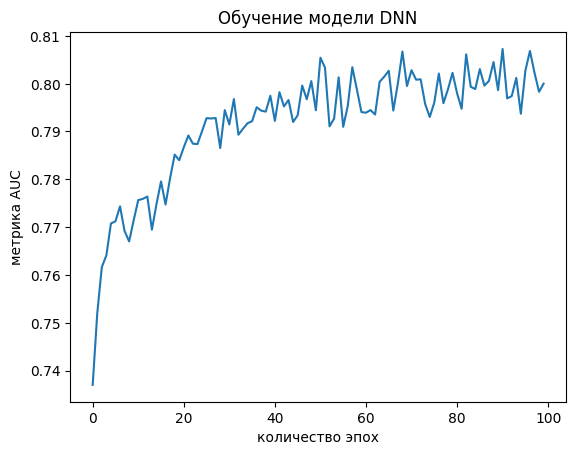

In [238]:
history = models['WrapperMyDNN: {"epochs": 100, "batch_size": 512, "hidden": 32}'].history
plt.title('Обучение модели DNN')
pd.Series(history).plot(xlabel='количество эпох', ylabel='метрика AUC')
plt.show()